## Imports

In [3]:
import numpy as np
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import scipy 
from numba import njit, prange
from pyccel.epyccel import epyccel
from pyccel.decorators import types
import subprocess
import os
import shutil
import sys
import re
import pytest
import time

## Pure python function

In [4]:

def solve_2d_burger_pure(u, un, v, vn, nt, dt, dx, dy, nu):
    
    
    ###Assign initial conditions
    ##set hat function I.C. : u(.5<=x<=1 && .5<=y<=1 ) is 2
 u[int(.5 / dy):int(1 / dy + 1),int(.5 / dx):int(1 / dx + 1)] = 2 
    ##set hat function I.C. : u(.5<=x<=1 && .5<=y<=1 ) is 2
 v[int(.5 / dy):int(1 / dy + 1),int(.5 / dx):int(1 / dx + 1)] = 2
 row, col = u.shape
 for n in range(nt + 1): ##loop across number of time steps
    un = u.copy()
    vn = v.copy()

    u[1:-1, 1:-1] = (un[1:-1, 1:-1] -
                     dt / dx * un[1:-1, 1:-1] * 
                     (un[1:-1, 1:-1] - un[1:-1, 0:-2]) - 
                     dt / dy * vn[1:-1, 1:-1] * 
                     (un[1:-1, 1:-1] - un[0:-2, 1:-1]) + 
                     nu * dt / dx**2 * 
                     (un[1:-1,2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) + 
                     nu * dt / dy**2 * 
                     (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1]))
    
    v[1:-1, 1:-1] = (vn[1:-1, 1:-1] - 
                     dt / dx * un[1:-1, 1:-1] *
                     (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                     dt / dy * vn[1:-1, 1:-1] * 
                    (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) + 
                     nu * dt / dx**2 * 
                     (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                     nu * dt / dy**2 *
                     (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1]))
     
    u[0, :] = 1
    u[-1, :] = 1
    u[:, 0] = 1
    u[:, -1] = 1
    
    v[0, :] = 1
    v[-1, :] = 1
    v[:, 0] = 1
    v[:, -1] = 1   

        
        
 return 0

## Numba accelerator

In [5]:
@njit(parallel=True , nopython=True , fastmath=True)
def solve_2d_burger_numba(u, un, v, vn, nt, dt, dx, dy, nu):
    
    
    ###Assign initial conditions
    ##set hat function I.C. : u(.5<=x<=1 && .5<=y<=1 ) is 2
 u[int(.5 / dy):int(1 / dy + 1),int(.5 / dx):int(1 / dx + 1)] = 2 
    ##set hat function I.C. : u(.5<=x<=1 && .5<=y<=1 ) is 2
 v[int(.5 / dy):int(1 / dy + 1),int(.5 / dx):int(1 / dx + 1)] = 2
 row, col = u.shape
 for n in prange(nt + 1): ##loop across number of time steps
    un = u.copy()
    vn = v.copy()

    u[1:-1, 1:-1] = (un[1:-1, 1:-1] -
                     dt / dx * un[1:-1, 1:-1] * 
                     (un[1:-1, 1:-1] - un[1:-1, 0:-2]) - 
                     dt / dy * vn[1:-1, 1:-1] * 
                     (un[1:-1, 1:-1] - un[0:-2, 1:-1]) + 
                     nu * dt / dx**2 * 
                     (un[1:-1,2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) + 
                     nu * dt / dy**2 * 
                     (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1]))
    
    v[1:-1, 1:-1] = (vn[1:-1, 1:-1] - 
                     dt / dx * un[1:-1, 1:-1] *
                     (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                     dt / dy * vn[1:-1, 1:-1] * 
                    (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) + 
                     nu * dt / dx**2 * 
                     (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                     nu * dt / dy**2 *
                     (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1]))
     
    u[0, :] = 1
    u[-1, :] = 1
    u[:, 0] = 1
    u[:, -1] = 1
    
    v[0, :] = 1
    v[-1, :] = 1
    v[:, 0] = 1
    v[:, -1] = 1    
    #fill the update of u and v
        
        
 return 0

/home/babou/.local/lib/python3.8/site-packages/numba/core/decorators.py:255: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


## Pyccel accelerator

In [21]:
@types('float[:,:]', 'float[:,:]','float[:,:]','float[:,:]', 'int' ,'float', 'float','float', 'float')

def solve_2d_burger_pyccel(u, un, v, vn, nt, dt, dx, dy, nu):
       ###Assign initial conditions
    ##set hat function I.C. : u(.5<=x<=1 && .5<=y<=1 ) is 2
 u[int(.5 / dy):int(1 / dy + 1),int(.5 / dx):int(1 / dx + 1)] = 2 
    ##set hat function I.C. : u(.5<=x<=1 && .5<=y<=1 ) is 2
 v[int(.5 / dy):int(1 / dy + 1),int(.5 / dx):int(1 / dx + 1)] = 2
 row, col = u.shape
 un [:,:]= u[:,:]
 vn[:,:] = v[:,:]

          
 for nt in range(0, nt + 1):
    for ix in range(1, row-1):
        for iy in range(1, col-1):
            u[ix, iy] = un[ix, iy] + (nu) * dt/(dx**2) * (
                    un[ix + 1, iy] - 2 * un[ix, iy] + un[ix - 1, iy]) + (nu) * dt/(dy**2) * (
                                        un[ix, iy + 1] - 2 * un[ix, iy] + un[ix, iy - 1]) - un[ix, iy] * (
                                        dt / float(dx)) * (un[ix, iy] - un[ix - 1, iy]) - vn[ix, iy] * (
                                        dt / float(dx)) * (un[ix, iy] - un[ix, iy - 1])   

            v[ix, iy] = vn[ix, iy] + nu* (dt / dx**2) * (
                    vn[ix + 1, iy] - 2 * vn[ix, iy] + vn[ix - 1, iy]) + (nu) * (dt/dy**2) * (
                                    vn[ix, iy + 1] - 2 * vn[ix, iy] + vn[ix, iy - 1]) - un[ix, iy] * (
                                    dt/ float(dx)) * (vn[ix, iy] - vn[ix - 1, iy]) - vn[ix, iy] * (
                                    dt/ float(dy)) * (vn[ix, iy] - vn[ix, iy - 1])

    u[0, :] = 1
    u[-1, :] = 1
    u[:, 0] = 1
    u[:, -1] = 1
    
    v[0, :] = 1
    v[-1, :] = 1
    v[:, 0] = 1
    v[:, -1] = 1 
    
    
  
        
        
 return 0

## Inputs

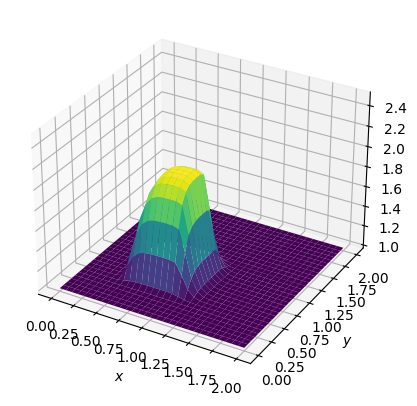

In [22]:
###variable declarations
nx = 31
ny = 31
nt = 120
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
sigma = .0009
nu = 0.01
dt = sigma * dx * dy / nu


x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)

u = np.ones((ny, nx))  # create a 1xn vector of 1's
v = np.ones((ny, nx))
un = np.ones((ny, nx)) 
vn = np.ones((ny, nx))

solve_2d_burger_pure(u, un, v, vn, nt, dt, dx, dy, nu)

X, Y = np.meshgrid(x, y)
fig = pyplot.figure(figsize=(7, 5), dpi=100)
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, u, rstride=1, cstride=1, cmap=cm.viridis, linewidth=0, antialiased=True)
ax.set_zlim(1, 2.5)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

## Call Funtions

### Pure function

In [23]:
%timeit solve_2d_burger_pure(u, un, v, vn, nt, dt, dx, dy, nu)

9.82 ms ± 64.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Function with numba accelerator

In [24]:
%timeit solve_2d_burger_numba(u, un, v, vn, nt, dt, dx, dy, nu)

568 µs ± 3.08 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Function with pyccel accelerator

In [25]:
solve_2d_burger_f90 = epyccel(solve_2d_burger_pyccel)

In [26]:
%timeit solve_2d_burger_f90(u, un, v, vn, nt, dt, dx, dy, nu)

395 µs ± 2.57 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
